# Customer Segmentation - Data Preprocessing

This notebook covers the data preprocessing steps for the customer segmentation project:
1. Loading the data
2. Exploring the raw data
3. Handling missing values
4. Detecting and addressing outliers
5. Feature scaling/normalization
6. Saving the preprocessed data

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Set plotting style
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Increase default figure size
plt.rcParams['figure.figsize'] = [12, 8]

## 1. Data Loading

In [2]:
# Load the customer behavior data
file_path = "../data/customer_behavior_analytcis.csv"
df = pd.read_csv(file_path)

# Display the first few rows
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (999, 6)


,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts,customer_id
0,7.0,129.34,52.17,18.0,0.0,CM00000
1,22.0,24.18,9.19,15.0,7.0,CM00001
2,2.0,32.18,90.69,50.0,2.0,CM00002
3,25.0,26.85,11.22,16.0,10.0,CM00003
4,7.0,125.45,34.19,30.0,3.0,CM00004


## 2. Initial Data Exploration

In [3]:
# Check data types and basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_purchases   979 non-null    float64
 1   avg_cart_value    979 non-null    float64
 2   total_time_spent  999 non-null    float64
 3   product_click     979 non-null    float64
 4   discount_counts   999 non-null    float64
 5   customer_id       999 non-null    object 
dtypes: float64(5), object(1)
memory usage: 47.0+ KB


In [4]:
# Get statistical summary
df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_purchases,979.0,11.570991,7.016327,0.00,6.000,10.00,17.000,32.00
avg_cart_value,979.0,75.457978,55.067835,10.26,33.130,49.38,121.255,199.77
total_time_spent,999.0,49.348759,32.730973,5.12,22.375,40.36,77.170,119.82
product_click,979.0,28.237998,16.296384,4.00,16.000,21.00,45.000,73.00
discount_counts,999.0,4.313313,4.532772,0.00,1.000,2.00,8.000,21.00


In [5]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Missing Percentage': missing_percentage.round(2)
})

# Display columns with missing values
missing_info[missing_info['Missing Values'] > 0]

,Missing Values,Missing Percentage
total_purchases,20,2.0
avg_cart_value,20,2.0
product_click,20,2.0


## 3. Handling Missing Values

In [6]:
# Create a copy of the original dataframe
df_clean = df.copy()

# Check for rows with multiple missing values
rows_with_multiple_missing = df_clean[df_clean.isnull().sum(axis=1) > 1]
print(f"Number of rows with multiple missing values: {len(rows_with_multiple_missing)}")

# Drop rows with too many missing values (if needed)
if len(rows_with_multiple_missing) > 0:
    df_clean = df_clean.dropna(thresh=df_clean.shape[1]-1)
    print(f"After dropping rows with multiple missing values: {df_clean.shape}")

Number of rows with multiple missing values: 20
After dropping rows with multiple missing values: (979, 6)


In [7]:
# Fill remaining missing values with median/mode
for column in df_clean.columns:
    if df_clean[column].isnull().sum() > 0:
        if pd.api.types.is_numeric_dtype(df_clean[column]):
            median_value = df_clean[column].median()
            df_clean[column].fillna(median_value, inplace=True)
            print(f"Filled missing values in '{column}' with median: {median_value}")
        else:
            mode_value = df_clean[column].mode()[0]
            df_clean[column].fillna(mode_value, inplace=True)
            print(f"Filled missing values in '{column}' with mode: {mode_value}")

# Verify no missing values remain
print(f"\nRemaining missing values: {df_clean.isnull().sum().sum()}")


Remaining missing values: 0


## 4. Detecting and Addressing Outliers

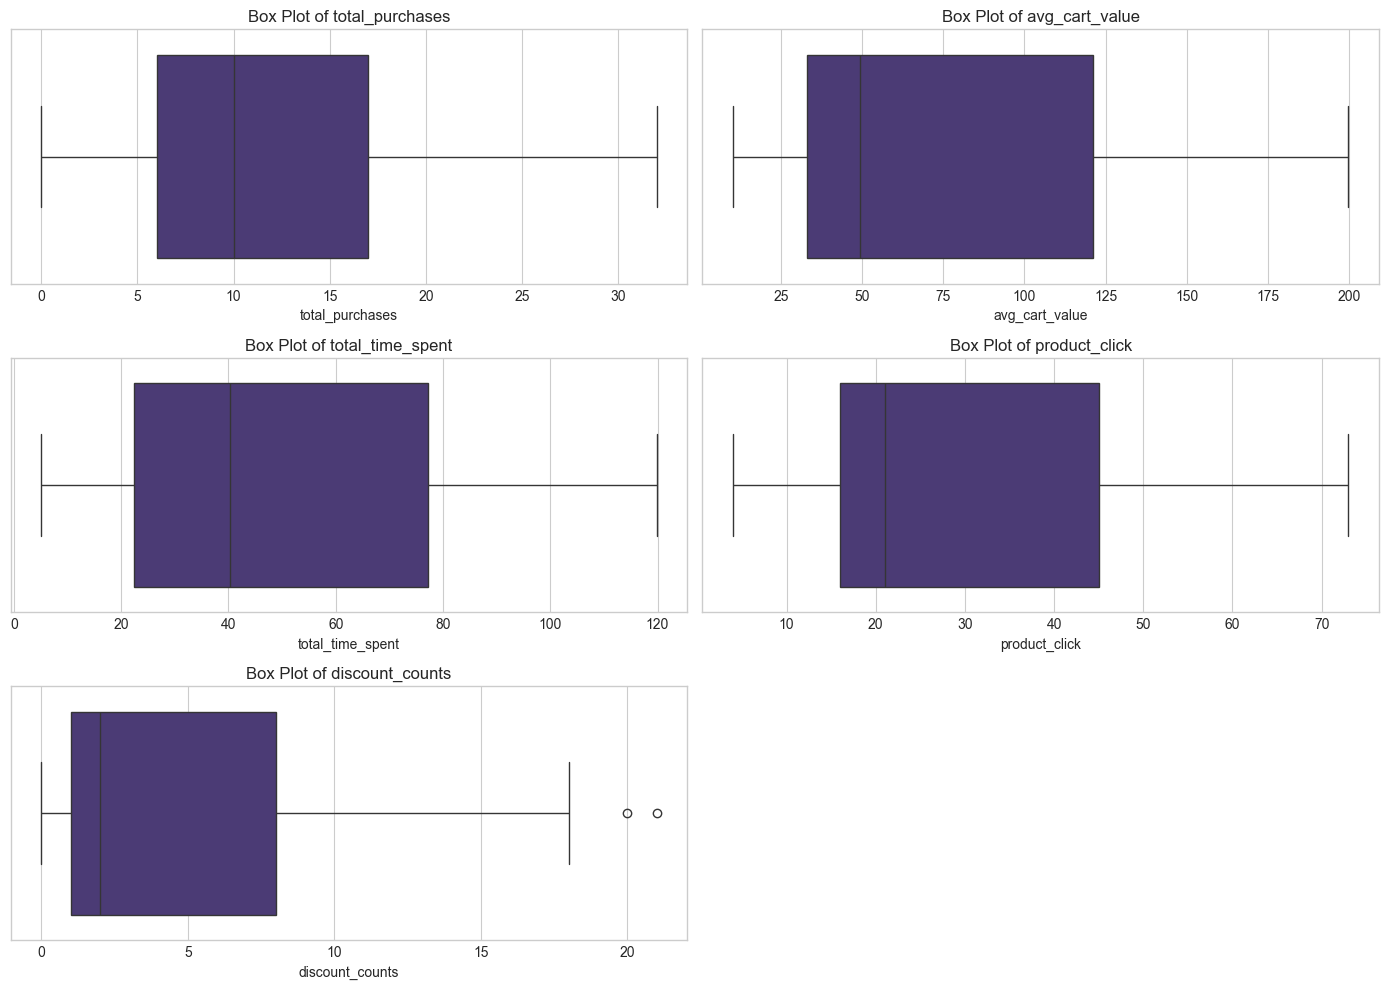

In [8]:
# Create box plots to visualize potential outliers
plt.figure(figsize=(14, 10))

# Select numeric columns excluding customer_id
numeric_columns = [col for col in df_clean.columns 
                   if pd.api.types.is_numeric_dtype(df_clean[col]) and col != 'customer_id']

for i, column in enumerate(numeric_columns):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x=df_clean[column])
    plt.title(f'Box Plot of {column}')
    
plt.tight_layout()
plt.show()

In [9]:
# Function to detect outliers using IQR method
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Check outliers in each feature
for column in numeric_columns:
    outliers, lower_bound, upper_bound = detect_outliers(df_clean, column)
    n_outliers = len(outliers)
    print(f"{column}: {n_outliers} outliers detected ({n_outliers/len(df_clean)*100:.2f}%)")
    print(f"    Bounds: ({lower_bound:.2f}, {upper_bound:.2f})")
    print(f"    Min: {df_clean[column].min()}, Max: {df_clean[column].max()}")
    print("")

total_purchases: 0 outliers detected (0.00%)
    Bounds: (-10.50, 33.50)
    Min: 0.0, Max: 32.0

avg_cart_value: 0 outliers detected (0.00%)
    Bounds: (-99.06, 253.44)
    Min: 10.26, Max: 199.77

total_time_spent: 0 outliers detected (0.00%)
    Bounds: (-60.08, 159.68)
    Min: 5.12, Max: 119.82

product_click: 0 outliers detected (0.00%)
    Bounds: (-27.50, 88.50)
    Min: 4.0, Max: 73.0

discount_counts: 2 outliers detected (0.20%)
    Bounds: (-9.50, 18.50)
    Min: 0.0, Max: 21.0



In [10]:
# For this segmentation problem, we'll keep the outliers
# They likely represent valid customer behaviors that are important for segmentation
print("Note: For customer segmentation, outliers often represent important customer behaviors.")
print("We'll keep outliers in the dataset as they may help identify distinct segments.")

Note: For customer segmentation, outliers often represent important customer behaviors.
We'll keep outliers in the dataset as they may help identify distinct segments.


## 5. Feature Scaling/Normalization

In [11]:
# Store the original dataframe before scaling
df_original = df_clean.copy()

# Identify columns to normalize (excluding customer_id if present)
columns_to_normalize = [col for col in df_clean.columns 
                        if pd.api.types.is_numeric_dtype(df_clean[col]) and col != 'customer_id']

# Create a StandardScaler
scaler = StandardScaler()

# Apply scaling to the selected columns
df_clean[columns_to_normalize] = scaler.fit_transform(df_clean[columns_to_normalize])

# Display the scaled data
print("Data after scaling:")
df_clean[columns_to_normalize].describe().T

Data after scaling:


,count,mean,std,min,25%,50%,75%,max
total_purchases,979.0,-3.628921e-18,1.000511,-1.649995,-0.794410,-0.224019,0.774163,2.913127
avg_cart_value,979.0,3.184378e-16,1.000511,-1.184563,-0.769044,-0.473803,0.832072,2.258588
total_time_spent,979.0,-7.257842e-18,1.000511,-1.350575,-0.825383,-0.276694,0.851202,2.149686
product_click,979.0,1.016098e-16,1.000511,-1.488084,-0.751348,-0.444374,1.029098,2.748148
discount_counts,979.0,5.261935e-17,1.000511,-0.955153,-0.733514,-0.511875,0.817959,3.699266


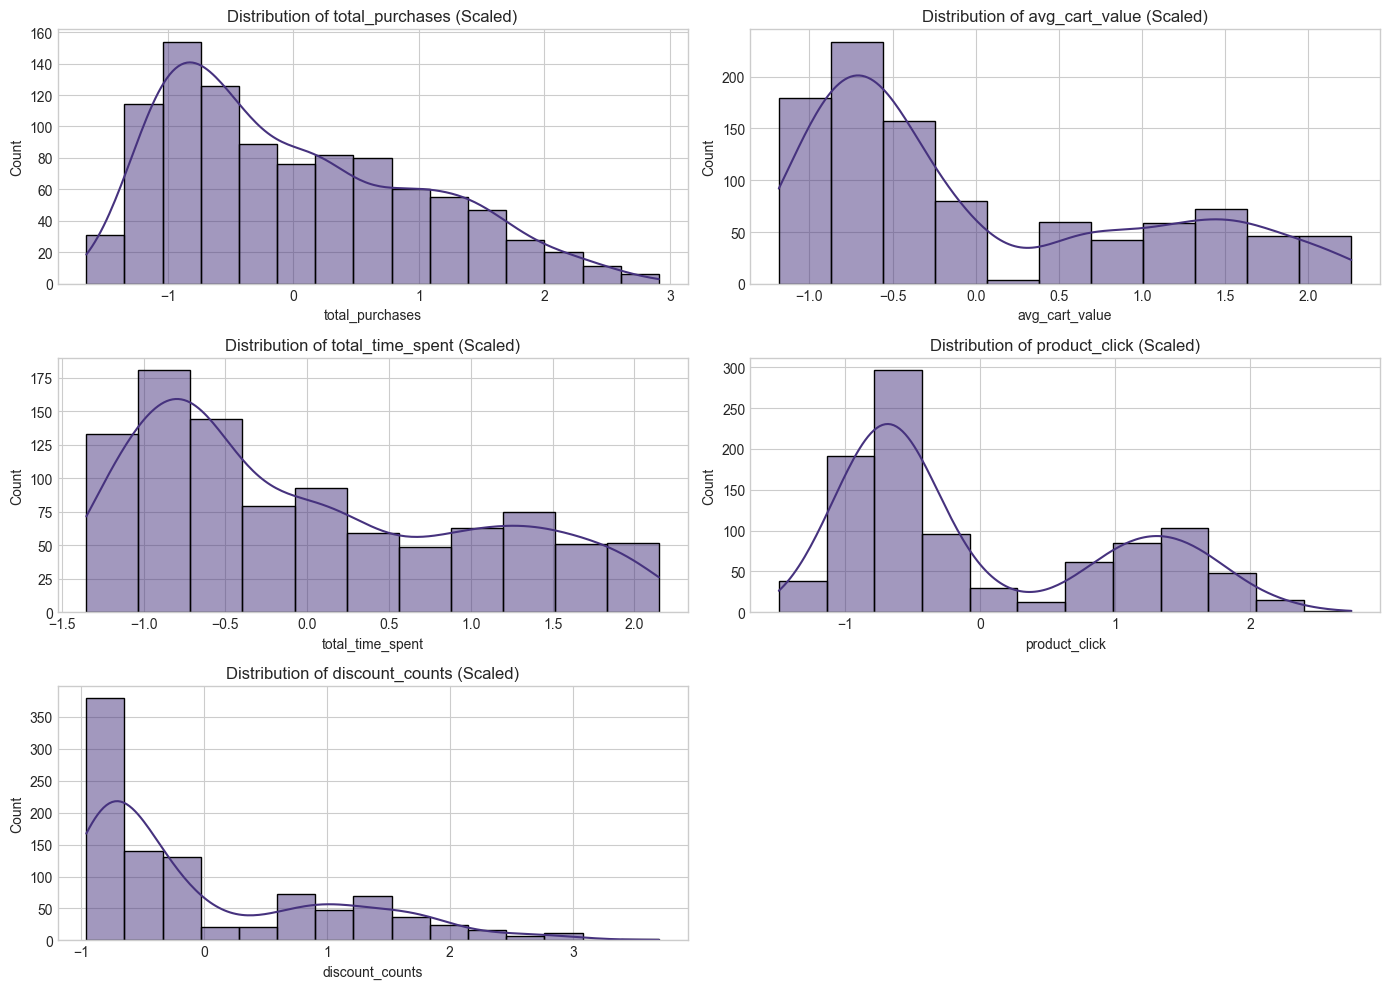

In [12]:
# Visualize the distribution of scaled features
plt.figure(figsize=(14, 10))

for i, column in enumerate(columns_to_normalize):
    plt.subplot(3, 2, i+1)
    sns.histplot(df_clean[column], kde=True)
    plt.title(f'Distribution of {column} (Scaled)')
    
plt.tight_layout()
plt.show()

## 6. Save Preprocessed Data

In [13]:
# Create an output directory if it doesn't exist
import os
os.makedirs('./output', exist_ok=True)

# Save the preprocessed data
df_clean.to_csv('./output/preprocessed_data.csv', index=False)
df_original.to_csv('./output/cleaned_data_unscaled.csv', index=False)

print(f"Preprocessed data saved to './output/preprocessed_data.csv'")
print(f"Cleaned unscaled data saved to './output/cleaned_data_unscaled.csv'")

Preprocessed data saved to './output/preprocessed_data.csv'
Cleaned unscaled data saved to './output/cleaned_data_unscaled.csv'


## Summary

In this notebook, we've completed the following preprocessing steps:

1. Loaded the customer behavior data
2. Explored the dataset's basic properties
3. Identified and handled missing values
4. Detected outliers (but kept them for segmentation purposes)
5. Normalized the features using StandardScaler
6. Saved both the preprocessed data and the cleaned unscaled data

The preprocessed data is now ready for exploratory data analysis and customer segmentation.